SNC Cell Tracking
===

Intro to this notebook goes here. This notebook is broken down into _n_ sections each with configurable options.

## Initialization

In [ ]:
import os
import sys
import imagej
import scipy.ndimage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scyjava as sj

from jpype import JInt
from imagej._java import jc

# initialize Fiji endpoint (ver 2.9.0) in interactive mode
run_mode = 'headless' # modes should be "headless" or "interactive"

ij_path = '/Applications/Fiji.app'
ij = imagej.init(ij_path,mode='headless',add_legacy=True)
print(f"ImageJ2/Fiji version: {ij.getVersion()}")

#ij = imagej.init('sc.fiji:fiji:2.9.0', mode=run_mode)
#print(f"ImageJ2/Fiji version: {ij.getVersion()}")

# load legacy ImageJ resources
DirectoryChooser = sj.jimport('ij.io.DirectoryChooser')
GenericDialog = sj.jimport('ij.gui.GenericDialog')
ResultsTable = sj.jimport('ij.measure.ResultsTable')
TextWindow = sj.jimport('ij.text.TextWindow')

# load ImageJ2/Fiji resources
Model = sj.jimport('fiji.plugin.trackmate.Model')
Settings = sj.jimport('fiji.plugin.trackmate.Settings')
TrackMate = sj.jimport('fiji.plugin.trackmate.TrackMate')
DogDetectorFactory = sj.jimport('fiji.plugin.trackmate.detection.DogDetectorFactory')
SelectionModel = sj.jimport('fiji.plugin.trackmate.SelectionModel')
#SimpleSparseLAPTrackerFactory = sj.jimport('fiji.plugin.trackmate.tracking.sparselap.SimpleSparseLAPTrackerFactory')
SparseLAPTrackerFactory = sj.jimport('fiji.plugin.trackmate.tracking.jaqaman.SparseLAPTrackerFactory')
#LAPUtils = sj.jimport('fiji.plugin.trackmate.tracking.LAPUtils')
LabelImgExporter = sj.jimport('fiji.plugin.trackmate.action.LabelImgExporter')
#label_id_painting = sj.jimport('fiji.plugin.trackmate.action.LabelImgExporter.LabelIdPainting')
DisplaySettingsIO = sj.jimport('fiji.plugin.trackmate.gui.displaysettings.DisplaySettingsIO')
FeatureFilter = sj.jimport('fiji.plugin.trackmate.features.FeatureFilter')
Table = sj.jimport('org.scijava.table.Table')

# load Java specific resources
Double = sj.jimport('java.lang.Double')

ImageJ2/Fiji version: 2.16.0/1.54p


TypeError: Class fiji.plugin.trackmate.tracking.LAPUtils is not found

## Configuration

Below is a table of the adjustable parameters:

| Parameter                   | Description                                           | Default value        |
| ---------                   | -----------                                           | -------------        |
| `time`                      | Time interval between frames in minutes.              | `30`                 |
| `outradius`                 | Define outlier radius to be removed.                  | `4`                  |
| `outthreshold`              | Define outlier threshold to be removed.               | `10`                 |
| `outwhich`                  | Define which outlier to be removed.                   | `Bright`             |
| `diameter`                  | Estimated object diameter in pixels.                  | `20`                 |
| `threshold`                 | Quality threshold.                                    | `0.5`                |
| `medianfilter`              | Enable pre-processing with median filter.             | `True`               |
| `subpixel`                  | Enable sub-pixel localization.                        | `True`               |
| `channel`                   | Select the channel to analyze.                        | `1`                  |
| `quality`                   | TrackMate quality threshold.                          | `1.2`                |
| `link_distance`             | TrackMate object linking distance.                    | `15.0`               |
| `gap_distance`              | TrackMate object gap distance.                        | `15.0`               |
| `gap_frame`                 | TrackMate max frame gap.                              | `20`                 |
| `max_event_frame`           | Maximum number of events present in a single frame.   | `500`                |
| `min_event_frames_for_good` | Minimum number of frames for a good cell.             | `60`                 |
| `event_ext`                 | Number of frames to extend the event.                 | `0`                  |
| `event_pixel_size`          | Pixel size of the events (cell size).                 | `11`                 |
| `input_dir`                 | Input directory.                                      | `"/path/to/input/"`  |
| `output_dir`                | Output directory.                                     | `"/path/to/output/"` |

In [18]:
pipeline_params = {
    "time": 30,
    "outradius": 4,
    "outthreshold": 10,
    "outwhich": "Bright", # valid options: "Bright", "Dark"
    "diameter": 20.0,
    "threshold": 0.5,
    "medianfilter": True,
    "subpixel": True,
    "channel": 1,
    "quality": 1.2,
    "link_distance": 15.0,
    "gap_distance": 15.0,
    "gap_frame": 20,
    "max_event_frame": 500,
    "min_event_frames_for_good": 60,
    "event_ext": 0,
    "event_pixel_size": 11,
    "input_dir": "/Volumes/BAGGINS/TRD2_Harrington_Data/DBPHarrington/Results/TRD2_protocol/sample_data",
    "output_dir": "/Volumes/BAGGINS/TRD2_Harrington_Data/DBPHarrington/Results/TRD2_protocol/output"
}

In [19]:
def setup():
    setup_params = {}
    if run_mode !="headless": 
        dc = DirectoryChooser("Choose a folder")
        path = dc.getDirectory()
        if path is None:
            print("User Canceled")
            return
        else:
            gd = GenericDialog(path)
            gd.addNumericField("Time interval between frames in minutes", 30,0)
            gd.addNumericField("Remove outliers radius", 4,0)
            gd.addNumericField("Remove outliers threshold", 10,0)
            gd.addChoice("Remove outliers which", ["Bright", "Dark"], "Bright")
            gd.addNumericField("Expected object diameter",20,2)
            gd.addNumericField("Quality Threshold",0.5,1)
            gd.addCheckbox("Pre-process with median filter:", True)
            gd.addCheckbox("Sub-pixel localization:", True)
            gd.addNumericField("Channel",1,0)
            gd.addNumericField("Spot detection Quality filter",1.2,1)
            gd.addNumericField("Linking max distance",15,1)
            gd.addNumericField("Gap-closing max distance",15,1)
            gd.addNumericField("Gap-close max frame gap",20,0)
            gd.addStringField("Output folder", "/home/user/output/", 60)
            gd.showDialog()
        if gd.wasCanceled():
            print("Setup canceled")
            return
        else:
            setup_params['time'] = str(gd.getNextNumber())
            setup_params['outradius'] = str(gd.getNextNumber())
            setup_params['outthreshold'] = str(gd.getNextNumber())
            setup_params['outwhich'] = str(gd.getNextChoice())
            setup_params['diameter'] = float(gd.getNextNumber())
            setup_params['threshold'] = float(gd.getNextNumber())
            setup_params['medianfilter'] = gd.getNextBoolean() 
            setup_params['subpixel'] = gd.getNextBoolean()
            setup_params['channel'] = JInt(gd.getNextNumber())
            setup_params['quality'] = float(gd.getNextNumber())
            setup_params['link_distance'] = float(gd.getNextNumber())
            setup_params['gap_distance'] = float(gd.getNextNumber())
            setup_params['gap_frame'] = JInt(gd.getNextNumber())
            setup_params['output_dir'] = str(gd.getNextString())
            setup_params['input_dir'] = str(path)
            return setup_params
    else:
        #code to set the params
        return params

## Detection and Tracking

This section detects and produces tracks.

In [20]:
detection_results = {}
file_type = '.tif'
files = os.listdir(pipeline_params['input_dir'])
for f in files:
    if f[-4:] == file_type:
        name = f.split(".")[0]
        imp = ij.IJ.openImage(os.path.join(pipeline_params['input_dir'], f))
        imp.show()
        ij.IJ.selectWindow(name + file_type)
        
        # get number of frames/slices
        # Assuming 3D data, the first two dimensions in ImageJ are always
        # X and Y, thus the last dimension will be frames/slices
        for i in range(len(imp.dims)):
            if (imp.dims[i] != 'X') and (imp.dims[i] != 'Y'):
                frames = imp.shape[i]

        ij.IJ.run(imp, "Properties...", "channels=1 slices=1 frames=" + str(frames) + " pixel_width=1.0000 pixel_height=1.0000 voxel_depth=1.0000 frame=[" + str(pipeline_params['time']) +" min]")
        ij.IJ.run(imp, "Despeckle", "stack")
        ij.IJ.run("Despeckle", "stack")
        ij.IJ.run("Despeckle", "stack")
        ij.IJ.run(imp, "Remove Outliers...", "radius=" + str(pipeline_params['outradius']) + " threshold=" + str(pipeline_params['outthreshold']) + " which=" + str(pipeline_params['outwhich']) +" stack")
        detection_results['raw_image'] = ij.WindowManager.getImage(name + '.tif').duplicate() # save raw/processed image

        model = Model()
        settings = Settings(imp)
        radius = float(pipeline_params['diameter']) / 2
        settings.detectorFactory = DogDetectorFactory()
        settings.detectorSettings = {
            'DO_SUBPIXEL_LOCALIZATION': pipeline_params['subpixel'],
            'RADIUS': radius,
            'TARGET_CHANNEL': JInt(pipeline_params['channel']),
            'THRESHOLD': float(pipeline_params['threshold']),
            'DO_MEDIAN_FILTERING': pipeline_params['medianfilter']
        }
        filter = FeatureFilter('QUALITY', float(pipeline_params['quality']), True)
        settings.addSpotFilter(filter)
        settings.trackerFactory = SimpleSparseLAPTrackerFactory()
        settings.trackerSettings = LAPUtils.getDefaultLAPSettingsMap()
        settings.trackerSettings['LINKING_MAX_DISTANCE'] = float(pipeline_params['link_distance'])
        settings.trackerSettings['GAP_CLOSING_MAX_DISTANCE'] = float(pipeline_params['gap_distance'])
        settings.trackerSettings['MAX_FRAME_GAP'] = JInt(pipeline_params['gap_frame'])
        tm = TrackMate(model, settings)

        # check TrackMate input and process
        if not tm.checkInput():
            sys.exit(str(tm.getErrorMessage()))

        sm = SelectionModel(model) # needed?
        tm.process()
        use_spots_as_id = True
        export_spots = True
        export_tracks = True
        label_img = LabelImgExporter.createLabelImagePlus(tm, export_spots, export_tracks, use_spots_as_id)
        detection_results['label_image'] = label_img.duplicate() # save label image
        label_img.show()
        ij.IJ.saveAs("Tiff", os.path.join(pipeline_params['output_dir'], name + '_lblImg.tif'))
        ij.IJ.run("Close")

        export_spots = False
        export_tracks = True
        spot_img = LabelImgExporter.createLabelImagePlus(tm, export_spots, export_tracks, use_spots_as_id)
        spot_img.show()
        ij.IJ.saveAs("Tiff", os.path.join(pipeline_params['output_dir'], name + '_SpotImg.tif'))
        ij.IJ.run(imp, "Merge Channels...", "c4=" + name + ".tif c6=" + name + "_SpotImg.tif keep ignore")
        ij.IJ.run(imp, "RGB Color", "frames")
        ij.IJ.saveAs("Tiff",os.path.join(pipeline_params['output_dir'], name + '_merge.tif'))
        ij.IJ.run("Close")

        fm = model.getFeatureModel()
        rt = ij.WindowManager.getWindow("TrackMate Results")

        # table stuff
        if (rt == None) or not (isinstance(rt, TextWindow)):
            table = ResultsTable()
        else:
            table = rt.getTextPanel().getOrCreateResultsTable()
        table.reset

        for id in model.getTrackModel().trackIDs(True):
            v = fm.getTrackFeature(id, 'TRACK_MEAN_SPEED')
            model.getLogger().log('')
            model.getLogger().log('Track ' + str(id) + ': mean velocity = ' + str(v) + ' ' + str(model.getSpaceUnits()) + '/' + str(model.getTimeUnits()))
            track = model.getTrackModel().trackSpots(id)
            for spot in track:
                sid = spot.ID()
                x = spot.getFeature('POSITION_X')
                y = spot.getFeature('POSITION_Y')
                t = spot.getFeature('FRAME')
                q = spot.getFeature('QUALITY')
                model.getLogger().log('\tspot ID = ' + str(sid) + ': x=' + str(x) + ', y=' + str(y) + ', t=' + str(t) + ', q=' + str(q))
                table.incrementCounter()
                table.addValue('TRACK_ID', Double(id))
                table.addValue('SPOT_ID', sid)
                table.addValue('POSITION_X', x)
                table.addValue('POSITION_Y', y)
                table.addValue('FRAME', t)
                table.addValue('QUALITY', q)

        table.show("TrackMate Results")
        ij.WindowManager.getWindow("TrackMate Results").rename(name + '.csv')
        ij.IJ.saveAs("Measurements", os.path.join(pipeline_params['output_dir'], name + '.csv'))
        ij.IJ.selectWindow(name + '.csv')
        ij.IJ.run("Close")
        detection_results['raw_image'].show()
        ij.IJ.selectWindow('DUP_' + name + '.tif')
        ij.IJ.saveAs("Tiff",os.path.join(pipeline_params['output_dir'], name + '_processed.tif'))
        detection_results['tracks'] = ij.py.from_java(ij.convert().convert(table, Table)) # convert ResultsTable to pandas dataframe

Operating in headless mode - the original ImageJ will have limited functionality.


ImportError: The original ImageJ is not available in this environment. The ij.IJ class is not available. See: https://github.com/imagej/pyimagej/blob/main/doc/Initialization.md

## Process tracks

This section processes tracks.

/home/edward/mambaforge/envs/pyijdev/lib/python3.10/site-packages/scipy/ndimage/_measurements.py:684: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(count).astype(numpy.float64)
/home/edward/mambaforge/envs/pyijdev/lib/python3.10/site-packages/scipy/ndimage/_measurements.py:684: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(count).astype(numpy.float64)
/home/edward/mambaforge/envs/pyijdev/lib/python3.10/site-packages/scipy/ndimage/_measurements.py:684: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(count).astype(numpy.float64)
/home/edward/mambaforge/envs/pyijdev/lib/python3.10/site-packages/scipy/ndimage/_measurements.py:684: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(count).astype(numpy.float64)
/home/edward/mambaforge/envs/pyijdev/lib/python3.10/site-packages/scipy/ndimage/_measurements.py:684: RuntimeWarning: invalid value encounte

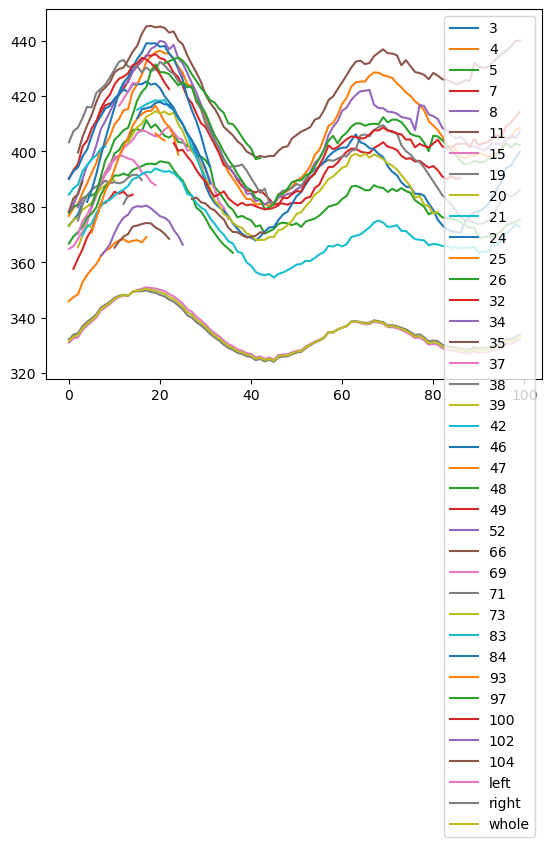

In [4]:
# convert ImagePlus to numpy.ndarray
if isinstance(detection_results['label_image'], jc.ImagePlus):
    label_image = ij.py.to_xarray(detection_results['label_image']).data
if isinstance(detection_results['raw_image'], jc.ImagePlus):
    raw_image = ij.py.to_xarray(detection_results['raw_image']).data

length = raw_image.shape[0]
c = int(raw_image.shape[1] / 2)
raw_image_left = raw_image[:, :, :c]
raw_image_right = raw_image[:, :, c:]

# sort the input dataframe for event ROI based on event number and frame number
df = detection_results['tracks'].where(detection_results['tracks'].notnull(), None)
df = df.sort_values(by=['TRACK_ID', 'FRAME'])
df['TRACK_ID'] = df['TRACK_ID'] +  1
df['FRAME'] = df['FRAME'] + 1

# filter events around cell movements
tracks = df.groupby('FRAME').agg(**{'TRACK_COUNT': pd.NamedAgg(column='TRACK_ID', aggfunc='nunique'), 'TRACK_LIST': pd.NamedAgg(column='TRACK_ID', aggfunc='unique')})
multi_tracks = tracks.drop(tracks[tracks.TRACK_COUNT <= pipeline_params['max_event_frame']].index)
multi_tracks = multi_tracks.explode('TRACK_LIST')
multi_tracks_list = multi_tracks.TRACK_LIST.unique()
bad_tracks = multi_tracks_list.tolist()

# save the x, y position at the start and end of the track for each event
track_dict = {}
for index, row in df.iterrows():
    if row['TRACK_ID'] != None:
        if row['TRACK_ID'] not in bad_tracks:
            track_id = int(row['TRACK_ID'])
            if track_id not in list(track_dict.keys()):
                track_dict[track_id] = {}
                track_dict[track_id]['start_frame'] = track_dict[track_id]['stop_frame'] = row['FRAME']
                track_dict[track_id]['start_x'] = track_dict[track_id]['stop_x'] = row['POSITION_X']
                track_dict[track_id]['start_y'] = track_dict[track_id]['stop_y'] = row['POSITION_Y']
            else:
                track_dict[track_id]['stop_frame'] = row['FRAME']
                track_dict[track_id]['stop_x'] = row['POSITION_X']
                track_dict[track_id]['stop_y'] = row['POSITION_Y']
track_list = list(track_dict.keys())

# filter tracks that are just 1 frame
for t in track_list:
    if int(track_dict[t]['stop_frame']) - int(track_dict[t]['start_frame']) < 1:
        del track_dict[t]
track_list = list(track_dict.keys())

# add ROI in the same x, y position at the start and end of the track event_ext number of frames
for t in track_list:
    start = int(track_dict[t]['start_frame']) - pipeline_params['event_ext']
    stop = int(track_dict[t]['stop_frame']) + pipeline_params['event_ext'] + 1
    if start <= 0:
        start = 1
    else:
        start = start
    if stop > length:
        stop = length
    else:
        stop = stop
    for frame in range(start, stop, 1):
        if t not in label_image[frame]:
            label_image[frame] - np.where(label_image[frame - 1] == t, t, label_image[frame])

# dilate ROI to pixel_size of event
for frame in range(length):
    a = label_image[frame]
    b = scipy.ndimage.maximum_filter(a, pipeline_params['event_pixel_size'])
    b[a != 0] = a[a != 0]
    label_image[frame] = b

# create scipy labels
labels = scipy.ndimage.label(label_image)

# save measurement of event pre filtering
pre_filter_df = pd.DataFrame(index=track_list)
for frame in range(length):
    pre_filter_df[frame] = scipy.ndimage.median(raw_image[frame], labels=labels[0][frame], index=track_list)
pre_filter_df = pre_filter_df.T
pre_filter_df['timepoint'] = pre_filter_df.index
pre_filter_df.dropna(axis='columns', how='all', inplace=True)
#pre_filter_df.to_csv(os.path.join(output_folder, 'Beforefilter' + movie + '.csv'))

# filter good cells/tracks -- here you can choose the min number of frames for good tracks
good_tracks = []
for t in track_list:
    start = int(track_dict[t]['start_frame'])
    stop = int(track_dict[t]['stop_frame'])
    l = stop - start
    if l > pipeline_params['min_event_frames_for_good']:
        good_tracks.append(t)

post_filter_df = pd.DataFrame(index=track_list)
post_filter_df = post_filter_df[post_filter_df.index.isin(good_tracks)]

# measure the mean intensity of good tracks
for frame in range(length):
    post_filter_df[frame] = scipy.ndimage.mean(raw_image[frame], labels=labels[0][frame], index=good_tracks)
post_filter_df = post_filter_df.T
post_filter_df.dropna(axis='columns', how='all', inplace=True)
#post_filter_df.to_csv(os.path.join(output_folder, 'Afterfilter' + movie + '.csv'))

# measure the mean intensity of the entire, left and right side of the image
y0 = []
y1 = []
y2 = []
for i in range(raw_image.shape[0]):
    y0.append(raw_image_left[i, :, :].mean())
    y1.append(raw_image_right[i, :, :].mean())
    y2.append(raw_image[i, :, :].mean())

y0_df = pd.DataFrame(y0)
y1_df = pd.DataFrame(y1)
y2_df = pd.DataFrame(y2)

post_filter_df['left'] = y0_df
post_filter_df['right'] = y1_df
post_filter_df['whole'] = y2_df

# save mean intensity of good tracks
#post_filter_df.to_csv(os.path.join(output_folder, 'complete_' + movie + '.csv'))
post_filter_df.plot.line(legend=True)
plt.show()